# FACE: Facial Associative Coupling in Expression - processing pipeline

In [29]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import util.feature_selection as fs
import util.correlation_measure as cm
import util.validation_testing as val
import util.toolbox as toolbox
import util.visualisation as vis

from scipy.stats import spearmanr, linregress
import statsmodels.formula.api as smf


In [30]:
# Setting constants, preparing file structure, checking file content
LOCATION = "data"
ACTION_UNITS = "data/au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = ['instructional_video_0', 'discussion_phase_0', *[f'reschu_run_{i}' for i in range(4)], 'discussion_phase_1', *[f'reschu_run_{4+i}' for i in range(4)]]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']

PAIRS = [f'0{i}_0{i+1}' for i in np.arange(5,9,2)]
PAIRS.append("09_10")
PAIRS.extend([f'{i}_{i+1}' for i in np.arange(11,104,2)])

AVAILABLE_PAIRS = ['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '15_16', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']
SKIP_PAIRS = ['53_54', '55_56', "63_64", "89_90"]


# make dirs
for file in os.listdir(ACTION_UNITS):
    if ".csv" in file and 'Data' in file: 
        filename = os.path.join(ACTION_UNITS, file)
        participant, _ = file.split("_",1)
        participant = participant[2:]
        for p in PAIRS:
            p1,p2 = p.split("_")
            if participant == p1 or participant == p2:
                pair = p
                break
        if pair in SKIP_PAIRS:
            continue
        if pair not in AVAILABLE_PAIRS:
            AVAILABLE_PAIRS.append(pair)
            dir = os.path.join(LOCATION, pair)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, FEATURE_FOLDER)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
            os.makedirs(dir, exist_ok=True)

print(f"Found {len(AVAILABLE_PAIRS)} available pairs to process.")

# SCORES OUT OF RESCHU
scores = pd.read_csv('RESCHU-data/teamscores_allParticipants_filtered.csv')
scores = scores[['SubjectId', 'reschuRun', 'TeamTotal']]

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    df = scores[scores['SubjectId'] == int(p1)]
    score = [[df['reschuRun'].values[i], df['TeamTotal'].values[i]] for i in range(len(df))]
    RESCHU_DATA[pair] = {
        'score' : score,
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }
RESCHU_DATA['51_52']['score'] = [[0, None]] + RESCHU_DATA['51_52']['score'] # because 51_52 misses the score for reschu_run_0

# print example RESCHU data
print(f'Example RESCHU data for pair 51_52: \nscore: {RESCHU_DATA['51_52']['score']}\nzoom: {RESCHU_DATA['51_52']['zoom']}\nbeeps: {RESCHU_DATA['51_52']['beeps']}')

RADIUS = {
    'f1': 0.075,
    'f2': 0.075, 
    'f3': 0.05,
    'f4': 0.05,
    'f5': 0.1,
    'f6': 0.025,
}

REMOVE_NEM = {
    'f1': 0,
    'f2': 0,
    'f3': 0,
    'f4': 0,
    'f5': 0,
    'f6': 0,
}


# Check for missing data
missing_pairs = []
phase_missing = {}
missing_counts = {}

for pair in PAIRS:
    p1, p2 = pair.split("_")
    missing_phases = []
    
    for phase in PHASES:
        p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
        p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")
        
        if not (os.path.exists(p1_file) and os.path.exists(p2_file)):
            missing_phases.append(phase)
    
    if len(missing_phases) == len(PHASES):
        missing_pairs.append(pair)
    elif missing_phases:
        phase_missing[pair] = missing_phases
        # Update missing counts statistics
        count = len(missing_phases)
        missing_counts[count] = missing_counts.get(count, 0) + 1

# Generate report
total_pairs = len(PAIRS)
max_phases = len(PHASES)

print("\n\n=== Data Completeness Report ===")
print(f"\nTotal pairs processed: {total_pairs}")
print(f"\nPairs with missing data: {len(missing_pairs) + len(phase_missing)}")
print(f"Complete pairs (no missing phases): {total_pairs - len(missing_pairs) - len(phase_missing)}")

print("\nMissing phases summary:")
print(f"- Missing all phases ({max_phases}): {len(missing_pairs)}")
for count in sorted(missing_counts.keys()):
    print(f"- Missing {count} phase(s): {missing_counts[count]}")

print("\nDetailed breakdown:")
print("\nPairs with all phases missing:")
if missing_pairs:
    for pair in missing_pairs:
        print(f"  - {pair}")
else:
    print("  None")

print("\nPairs with specific phases missing:")
if phase_missing:
    for pair, phases in phase_missing.items():
        print(f"  - {pair}: Missing {len(phases)} phases ({', '.join(phases)})")
else:
    print("  None")

Found 44 available pairs to process.
Example RESCHU data for pair 51_52: 
score: [[0, None], [1, 5], [2, 1], [3, 10], [4, 3], [5, 11], [6, 8], [7, 12]]
zoom: False
beeps: [False, True, False, True, False, True, False, True]


=== Data Completeness Report ===

Total pairs processed: 50

Pairs with missing data: 35
Complete pairs (no missing phases): 15

Missing phases summary:
- Missing all phases (11): 5
- Missing 1 phase(s): 8
- Missing 2 phase(s): 3
- Missing 3 phase(s): 3
- Missing 4 phase(s): 7
- Missing 5 phase(s): 6
- Missing 6 phase(s): 1
- Missing 7 phase(s): 1
- Missing 9 phase(s): 1

Detailed breakdown:

Pairs with all phases missing:
  - 11_12
  - 15_16
  - 23_24
  - 57_58
  - 89_90

Pairs with specific phases missing:
  - 05_06: Missing 1 phases (instructional_video_0)
  - 17_18: Missing 6 phases (reschu_run_3, discussion_phase_1, reschu_run_4, reschu_run_5, reschu_run_6, reschu_run_7)
  - 19_20: Missing 1 phases (discussion_phase_0)
  - 25_26: Missing 1 phases (reschu_run_

# Feature selection


In [ ]:
## EXTRACTING FACIAL FACTORS AND CORRCA FOR EACH FILE SEPARATELY
if False: # set to False to prevent unnecessary processing
    for pair in AVAILABLE_PAIRS:
        print(f"{pair} is being processed...")
        p1, p2 = pair.split("_")
        for phase in PHASES: 
            p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
            p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")

            if os.path.exists(p1_file) and os.path.exists(p2_file): # make sure files exist
                p1_df = pd.read_csv(p1_file)
                p2_df = pd.read_csv(p2_file)

                # make equal length
                p1_df = p1_df.iloc[:len(p2_df)]
                p2_df = p2_df.iloc[:len(p1_df)]

                # remove all missing data
                mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
                p1_df = p1_df[~mask].reset_index(drop=True)
                p2_df = p2_df[~mask].reset_index(drop=True)

                # AU to factor for navigator
                p1_factors = fs.au_to_factors(p1_df)
                p1_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_factors.csv"), index=False)
                
                # AU to factor for pilot
                p2_factors = fs.au_to_factors(p2_df)
                p2_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_factors.csv"), index=False)

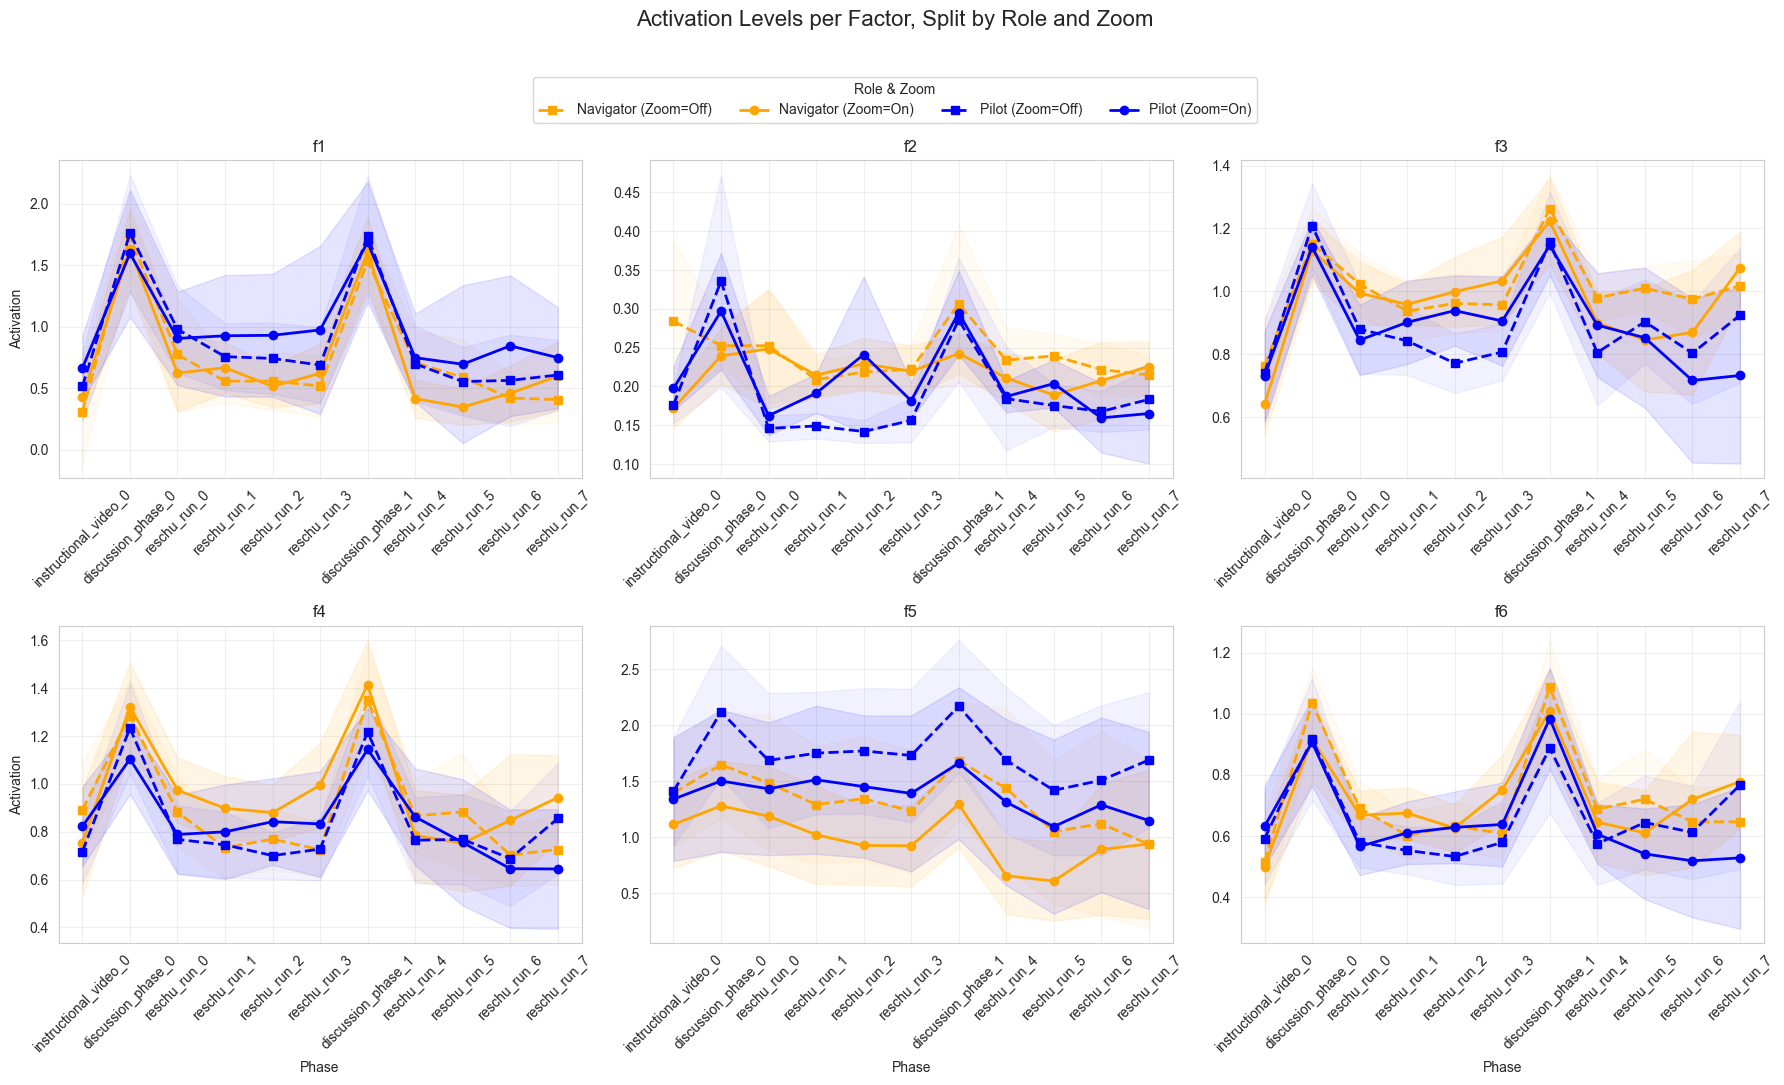

In [3]:
# 1. Collect all factor data with roles and zoom
all_data = pd.DataFrame(columns=['participant', 'zoom', 'role', 'phase', *FACTORS])

for pair in AVAILABLE_PAIRS:
    p1, p2 = pair.split("_")
    zoom = RESCHU_DATA[pair]['zoom']  # Assuming this returns True/False
    
    for phase in PHASES:
        p1_file = os.path.join(LOCATION, pair, FEATURE_FOLDER, f'pp{p1}_{phase}_factors.csv')
        p2_file = os.path.join(LOCATION, pair, FEATURE_FOLDER, f'pp{p2}_{phase}_factors.csv')
        
        if not os.path.exists(p1_file) and not os.path.exists(p2_file):
            continue
        
        if os.path.exists(p1_file):
            p_df = pd.read_csv(p1_file)
            factors = [np.mean(p_df[f].values) for f in FACTORS]
            all_data.loc[len(all_data)] = [p1, zoom, 'navigator', phase, *factors]
       
        if os.path.exists(p2_file):
            p_df = pd.read_csv(p2_file)
            factors = [np.mean(p_df[f].values) for f in FACTORS]
            all_data.loc[len(all_data)] = [p2, zoom, 'pilot', phase, *factors]

# 2. Melt the dataframe for plotting
plot_df = all_data.melt(id_vars=['participant', 'zoom', 'role', 'phase'], 
                        value_vars=FACTORS,
                        var_name='factor',
                        value_name='activation')

# 3. Calculate statistics including zoom
stats_df = (plot_df.groupby(['zoom', 'role', 'phase', 'factor'])['activation']
            .agg(['mean', 'count', 'std'])
            .reset_index())

stats_df['ci'] = 1.96 * stats_df['std'] / np.sqrt(stats_df['count'])
stats_df['phase'] = pd.Categorical(stats_df['phase'], categories=PHASES, ordered=True)
stats_df = stats_df.sort_values('phase')

# 4. Create plots with zoom split
sns.set_style("whitegrid")
palette = {'pilot': 'blue', 'navigator': 'orange'}
line_styles = {True: '-', False: '--'}  # Solid for zoom=True, dashed for zoom=False
markers = {True: 'o', False: 's'}       # Circle for zoom=True, square for zoom=False

# === Set up grid of subplots ===
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

sns.set_style("whitegrid")
palette = {'pilot': 'blue', 'navigator': 'orange'}
line_styles = {True: '-', False: '--'}  # Solid for zoom=True, dashed for zoom=False
markers = {True: 'o', False: 's'}       # Circle for zoom=True, square for zoom=False

for i, factor in enumerate(FACTORS):
    ax = axes[i]
    
    for (role, zoom), group in stats_df[stats_df['factor'] == factor].groupby(['role', 'zoom']):
        ax.plot(group['phase'], group['mean'], 
                color=palette[role],
                linestyle=line_styles[zoom],
                marker=markers[zoom],
                markersize=6,
                linewidth=2,
                label=f"{role.title()} (Zoom={'On' if zoom else 'Off'})")
        
        ax.fill_between(group['phase'],
                        group['mean'] - group['ci'],
                        group['mean'] + group['ci'],
                        color=palette[role],
                        alpha=0.1 if zoom else 0.05)
    
    ax.set_title(f'{factor}', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3)
    if i % 3 == 0:
        ax.set_ylabel("Activation")
    if i >= 3:
        ax.set_xlabel("Phase")

# Shared legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Role & Zoom', loc='upper center', bbox_to_anchor=(0.5, 1.02), ncol=4)

fig.suptitle("Activation Levels per Factor, Split by Role and Zoom", fontsize=16, y=1.08)
plt.tight_layout()
fig.savefig("activation_factors_by_zoom_and_role.png", dpi=300, bbox_inches='tight')
plt.show()

# cRQA

## Validation 

In [5]:
# Gridsearch
if False:
    toolbox.crqa_radius_gridsearch("gridsearch_NEW", radii = [0.001, 0.005, 0.010, 0.015, 0.020, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5])
    df = pd.read_csv('gridsearch_NEW.csv')
    toolbox.plot_crqa_radius_gridsearch(df, "gridsearch_NEW")


In [6]:
DEBUG = True

def process_dataframe(df, version_name, debug=False):
    """Helper function to process and validate dataframe."""
    df_validation = val.statistical_factor_analysis_aggregated(df, debug=debug)
    df_significant = df_validation[df_validation['p_fdr'] < 0.05]
    combinations = df_significant[['factor', 'comparison', 'p_value']].drop_duplicates()
    combinations['version'] = version_name
    if debug:
        print(f"Remaining factors for {version_name}: {combinations['factor'].unique()}\n")
    return df_validation


# # Initialize results dataframe
df = pd.read_csv('gridsearch_NEW.csv')
df = df[df['non_event_matches'] == 'excluded']
df = df[df.apply(lambda row: row['radius'] == RADIUS.get(row['factor']), axis=1)]
print(process_dataframe(df, "aggregated"))

  factor    comparison  statistic   p_value  n_real  n_fake     p_fdr
0     f1  real_vs_fake       74.0  0.465494      12      12  0.667497
1     f2  real_vs_fake       65.0  0.667497      12      12  0.667497
2     f3  real_vs_fake       73.0  0.488485      12      12  0.667497
3     f4  real_vs_fake       65.0  0.667497      12      12  0.667497
4     f5  real_vs_fake       78.0  0.375416      12      12  0.667497
5     f6  real_vs_fake       72.0  0.511515      12      12  0.667497


Significant comparisons (Mann-Whitney U, FDR-corrected):
  factor    comparison  statistic   p_value  n_real  n_fake     p_fdr
0     f1  real_vs_fake       74.0  0.465494      12      12  0.667497
1     f2  real_vs_fake       65.0  0.667497      12      12  0.667497
2     f3  real_vs_fake       73.0  0.488485      12      12  0.667497
3     f4  real_vs_fake       65.0  0.667497      12      12  0.667497
4     f5  real_vs_fake       78.0  0.375416      12      12  0.667497
5     f6  real_vs_fake       72.0  0.511515      12      12  0.667497
Remaining factors for aggregated: []



C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\2825392906.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\2825392906.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\2825392906.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=factor_df, x='condition', y='RR', palette='S

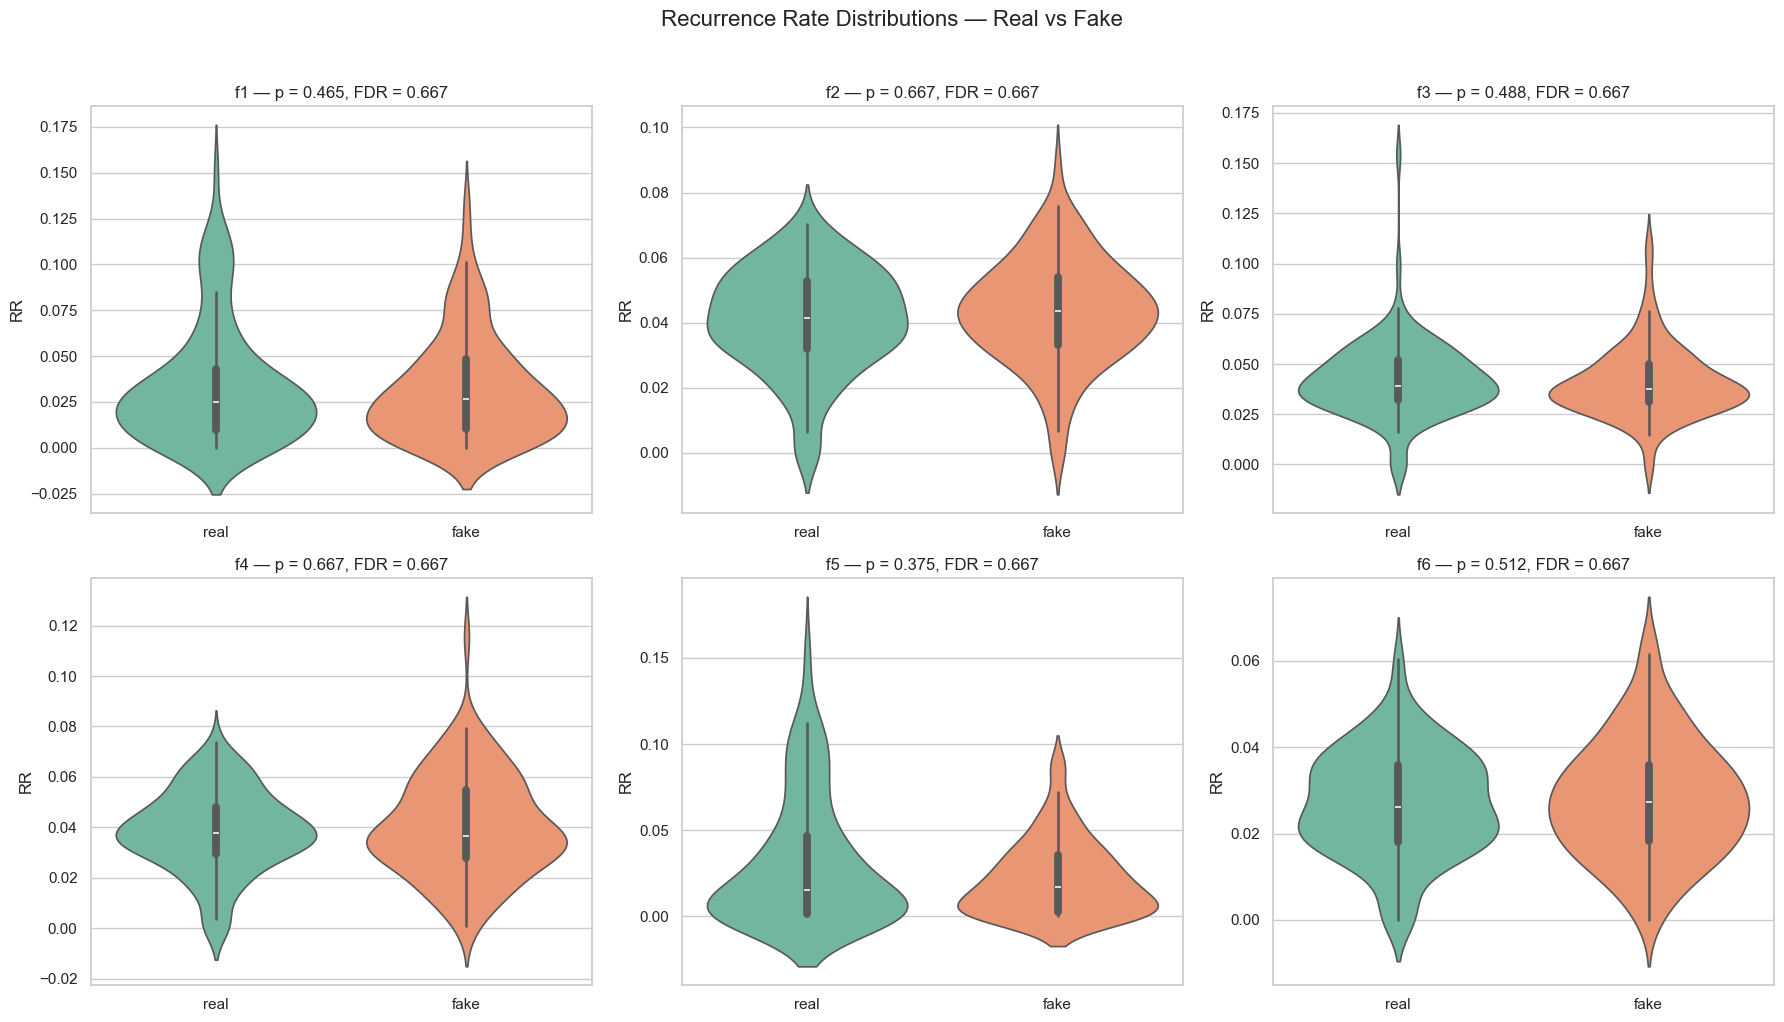

In [7]:

# Load and filter data
df = pd.read_csv('gridsearch_NEW.csv')
df = df[df['non_event_matches'] == 'excluded']
df = df[df.apply(lambda row: row['radius'] == RADIUS.get(row['factor']), axis=1)]
df['condition'] = df['condition'].str.lower()
df = df[df['condition'].isin(['real', 'fake'])]

# Get stats
results_df = process_dataframe(df, "aggregated", True)

# Plot setup
sns.set(style='whitegrid')
factors = df['factor'].unique()
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, factor in enumerate(factors):
    ax = axes[i]
    factor_df = df[df['factor'] == factor]

    # Get p-values
    try:
        p = results_df[results_df['factor'] == factor]['p_value'].values[0]
        p_fdr = results_df[results_df['factor'] == factor]['p_fdr'].values[0]
        title = f'{factor} — p = {p:.3f}, FDR = {p_fdr:.3f}'
    except IndexError:
        title = f'{factor} — p = n/a'

    # Plot
    sns.violinplot(data=factor_df, x='condition', y='RR', palette='Set2', inner='box', ax=ax)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('RR')

# Remove unused subplot if <6 factors
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Recurrence Rate Distributions — Real vs Fake", fontsize=16, y=1.02)
plt.tight_layout()
fig.savefig("rr_distributions_real_vs_fake.png", dpi=300, bbox_inches='tight')
plt.show()


In [8]:
if False:
    df = pd.read_csv('results/cRQA_gridsearch_RR.csv')
    toolbox.plot_crqa_radius_gridsearch(df, "cRQA_gridsearch_RR")


# cRQA run

In [9]:
full_run = False

RADIUS = {
    'f1': 0.075,
    'f2': 0.05, 
    'f3': 0.05,
    'f4': 0.05,
    'f5': 0.15,
    'f6': 0.025,
}

REMOVE_NEM = {
    'f1': 1,
    'f2': 1,
    'f3': 1,
    'f4': 1,
    'f5': 1,
    'f6': 1,
}


if False:
    joined_RR_overall = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score',*FACTORS])
    joined_RR_profile = pd.DataFrame(columns=['pair', 'zoom', 'phase', 'beeps', 'score', 'factor', *np.arange(-60,61)])

    for pair in AVAILABLE_PAIRS:
        print(f'{pair} is being processed')

        if not full_run and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv')) and os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv')) :
             continue
        
        p1, p2 = pair.split("_")
        RR_overall = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', *FACTORS])
        RR_profile = pd.DataFrame(columns=['zoom', 'phase', 'beeps', 'score', 'factor', *np.arange(-60,61)])

        pair_data = RESCHU_DATA[pair]
        zoom = pair_data['zoom']
        files = os.path.join(LOCATION, pair, FEATURE_FOLDER)
        for phase in PHASES:
            if 'reschu' in phase:
                if len(pair_data['score']) > int(phase[-1]):
                    beeps = pair_data['beeps'][int(phase[-1])]
                    score = pair_data['score'][int(phase[-1])][1]
                else:
                    beeps = None
                    score = None
            else: 
                beeps = None
                score = None

            components = []
            nav_file = os.path.join(files,f'pp{p1}_{phase}_factors.csv')
            pil_file = os.path.join(files,f'pp{p2}_{phase}_factors.csv')

            if not (os.path.exists(nav_file) and os.path.exists(pil_file)):
                print(f'{pair}-{phase} does not have both factor files')
                continue
            
            for f in FACTORS:
                nav = pd.read_csv(nav_file)
                pil = pd.read_csv(pil_file)

                fac = cm.crqa_lag_analysis(nav[f].values, pil[f].values, radius=RADIUS[f], remove_non_event_matches=REMOVE_NEM[f])
                components.append(fac['RR'])

                RR_profile.loc[len(RR_profile)] = [zoom, phase, beeps, score, f, *fac['rr_profile']]
                joined_RR_profile.loc[len(joined_RR_profile)] = [pair, zoom, phase, beeps, score, f, *fac['rr_profile']]
                
            RR_overall.loc[len(RR_overall)] = [zoom, phase, beeps, score, *components]
            joined_RR_overall.loc[len(joined_RR_overall)] = [pair, zoom, phase, beeps, score, *components]
            

        RR_overall.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv'), index=False)
        RR_profile.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv'), index=False)
        
if full_run:
    joined_RR_overall.to_csv(r"crqa_NEM-_overall.csv", index=False) 
    joined_RR_profile.to_csv(r"crqa_NEM-_profile.csv", index=False)


# Analysis

In [10]:
# SCORES OUT OF ENQUETE
## POST TRIAL TEAMWORK ASSESSMENT (per reschu_run)
post_trial = pd.read_csv('RESCHU-data/post_trial_enquete.csv')
post_trial = post_trial[['ParticipantID', 'Trial', 'Teamwork_1']] # TODO: extend if needed to fit more


## POST STUDY COHESION COOPERATION AN DEMPATHY ASSESSMENT
post_study = pd.read_csv('RESCHU-data/post_study_enquete.csv')
post_study['Cohe'] = (post_study['Cohesion_1'] + post_study['Cohesion_2'] + post_study['Cohesion_3'] + post_study['Cohesion_4'] + post_study['Cohesion_5'])/5
post_study['Coop'] = (post_study['Cooperation_1'] + post_study['Cooperation_2'] + post_study['Cooperation_3'] + post_study['Cooperation_4'] + post_study['Cooperation_5'] + post_study['Cooperation_6'] + post_study['Cooperation_7'] + post_study['Cooperation_8'] + post_study['Cooperation_9'])/9
for i in range(2,6):
    post_study['Cohesion_1'] = post_study['Cohesion_1'] + post_study[f'Cohesion_{i}']
post_study['Cohesion_1'] = post_study['Cohesion_1']/5
for i in range(2,10):
    post_study['Cooperation_1'] = post_study['Cooperation_1'] + post_study[f'Cooperation_{i}']
post_study['Cooperation_1'] = post_study['Cooperation_1']/9
for i in range(2,24):
    post_study['Empathy_1'] = post_study['Empathy_1'] + post_study[f'Empathy_{i}']
post_study['Empathy_1'] = post_study['Empathy_1']/23
post_study = post_study[['ParticipantID', 'Cohesion_1', 'Cooperation_1', 'Empathy_1']]



STUDY_ENQUETE = {}
TRIAL_ENQUETE = {}
for pair in AVAILABLE_PAIRS:
    p1, p2 = pair.split("_")
    p1_study = post_study[post_study['ParticipantID']== int(p1)]
    p2_study = post_study[post_study['ParticipantID']== int(p2)]

    p1_trial = post_trial[post_trial['ParticipantID'] == int(p1)]
    p2_trial = post_trial[post_trial['ParticipantID'] == int(p2)]

    trial = {}
    for i in range(1,9):
        p1_t = p1_trial[p1_trial['Trial'] == i]
        p2_t = p2_trial[p2_trial['Trial'] == i]
        if len(p1_t) > 0 and len(p2_t) > 0:
            trial[i] = p1_t['Teamwork_1'].values[0] + p2_t['Teamwork_1'].values[0]
    
    TRIAL_ENQUETE[pair] = trial

    if len(p1_study) > 0 and len(p2_study) > 0:
        STUDY_ENQUETE[pair] = {
            'Cohesion' : p1_study['Cohesion_1'].values[0] + p2_study['Cohesion_1'].values[0],
            'Cooperation' : p1_study['Cooperation_1'].values[0] + p2_study['Cooperation_1'].values[0],
            'Empathy': p1_study['Empathy_1'].values[0] + p2_study['Empathy_1'].values[0]
        }


print(TRIAL_ENQUETE['51_52'])
print(STUDY_ENQUETE['51_52'])

df = pd.read_csv('crqa_NEM-_overall.csv')

cohesion = []
cooperation = []
empathy = []
teamwork = []
for _, row in df.iterrows():
    if 'reschu' not in row['phase']: 
        teamwork.append(None)
    else:
        phase = int(row['phase'][-1]) + 1
        if phase in TRIAL_ENQUETE[row['pair']]:
            teamwork.append(TRIAL_ENQUETE[row['pair']][phase])
        else:
            teamwork.append(None)

    if row['pair'] in STUDY_ENQUETE:
        dic = STUDY_ENQUETE[row['pair']]
        cohesion.append(dic['Cohesion'])
        cooperation.append(dic['Cooperation'])
        empathy.append(dic['Empathy'])
    else:
        cohesion.append(None)
        cooperation.append(None)
        empathy.append(None)

df['Teamwork'] = teamwork
df['Cohesion'] = cohesion
df['Cooperation'] = cooperation
df['Empathy'] = empathy
df.head()

df.to_csv('crqa_NEM-_overall_questionnaire.csv')


{2: 140.0, 3: 179.0, 4: 133.0, 5: 55.0, 6: 174.0, 7: 98.0, 8: 178.0}
{'Cohesion': 11.4, 'Cooperation': 8.666666666666666, 'Empathy': 8.695652173913043}


## Comparing RR with dependent variables
 (objective) score; 

 (subjective) teamwork, cohesion, cooperation, empathy

In [11]:
df = pd.read_csv('crqa_NEM-_overall_questionnaire.csv')
print(df.columns)
# Run tests for each dependent variable
for dep_var in ['score', 'Teamwork', 'Cohesion', 'Cooperation', 'Empathy']:
    print(f"\n{'-'*20}\n{dep_var.upper()}\n{'-'*20}")
    avg_results, phase_results = val.run_significance_tests(df, dep_var)
    
    print("Average:")
    print(avg_results)
    print("\nExcluding intro + discussion. \nInspecting phases individually:")
    print(phase_results)

Index(['Unnamed: 0', 'pair', 'zoom', 'phase', 'beeps', 'score', 'f1', 'f2',
       'f3', 'f4', 'f5', 'f6', 'Teamwork', 'Cohesion', 'Cooperation',
       'Empathy'],
      dtype='object')

--------------------
SCORE
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index: []

Excluding intro + discussion. 
Inspecting phases individually:
        setting component       rho         p
0    all_reschu        f3  0.271168  0.000017
1    all_reschu        f5 -0.128463  0.044557
2   zoom = True        f3  0.274416  0.001649
3   zoom = True        f5 -0.184668  0.036166
4  zoom = False        f3  0.262645  0.004395
5  reschu_run_1        f3  0.477373  0.002119
6  reschu_run_2        f3  0.487070  0.001436
7  reschu_run_4        f6  0.458405  0.016183

--------------------
TEAMWORK
--------------------
Average:
Empty DataFrame
Columns: [setting, component, rho, p]
Index: []

Excluding intro + discussion. 
Inspecting phases individually:
        setting componen

# Experimental area

In [ ]:
df = pd.read_csv('crqa_NEM-_overall.csv')
print(np.unique(df['phase'].values))
zoom_new = []
for _, row in df.iterrows():
    zoom_new.append(RESCHU_DATA[row['pair']]['zoom'])
df['zoom'] = zoom_new
df.head()

['discussion_phase_0' 'discussion_phase_1' 'instructional_video_0'
 'reschu_run_0' 'reschu_run_1' 'reschu_run_2' 'reschu_run_3'
 'reschu_run_4' 'reschu_run_5' 'reschu_run_6' 'reschu_run_7']


,pair,zoom,phase,beeps,score,f1,f2,f3,f4,f5,f6
0,05_06,True,discussion_phase_0,NaN,NaN,0.0187,0.0214,0.0344,0.0295,0.0003,0.0343
1,05_06,True,reschu_run_0,True,4.0,0.0288,0.0333,0.0452,0.0491,0.0039,0.0406
2,05_06,True,reschu_run_1,False,11.0,0.0298,0.0287,0.0457,0.0521,0.0009,0.0413
3,05_06,True,reschu_run_2,True,23.0,0.0347,0.0315,0.0449,0.0404,0.0023,0.0327
4,05_06,True,reschu_run_3,False,21.0,0.0098,0.0353,0.0502,0.0452,0.0000,0.0322


['discussion_phase_0' 'discussion_phase_1' 'instructional_video_0'
 'reschu_run_0' 'reschu_run_1' 'reschu_run_2' 'reschu_run_3'
 'reschu_run_4' 'reschu_run_5' 'reschu_run_6' 'reschu_run_7']
Phase counts:
phase
instructional_video_0    38
discussion_phase_0       40
reschu_run_0             42
reschu_run_1             39
reschu_run_2             40
reschu_run_3             36
discussion_phase_1       37
reschu_run_4             27
reschu_run_5             23
reschu_run_6             21
reschu_run_7             18
Name: count, dtype: int64


C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\1054463436.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\1054463436.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  phase_terms['factor'] = factor
C:\Users\Erik\AppData\Local\Temp\ipykernel_13924\1054463436.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 


Mixed-Effects Coefficients by Phase:
        factor                                          term      coef  \
0    f1_scaled               phase_ord[T.discussion_phase_0] -0.354238   
1    f1_scaled                     phase_ord[T.reschu_run_0] -0.057720   
2    f1_scaled                     phase_ord[T.reschu_run_1] -0.012505   
3    f1_scaled                     phase_ord[T.reschu_run_2] -0.160367   
4    f1_scaled                     phase_ord[T.reschu_run_3] -0.083757   
..         ...                                           ...       ...   
115  f6_scaled  phase_ord[T.discussion_phase_1]:zoom[T.True]  0.260096   
116  f6_scaled        phase_ord[T.reschu_run_4]:zoom[T.True] -0.264620   
117  f6_scaled        phase_ord[T.reschu_run_5]:zoom[T.True] -0.476500   
118  f6_scaled        phase_ord[T.reschu_run_6]:zoom[T.True] -1.074619   
119  f6_scaled        phase_ord[T.reschu_run_7]:zoom[T.True] -0.579786   

         pval  
0    0.075752  
1    0.769171  
2    0.950092  
3    0.42

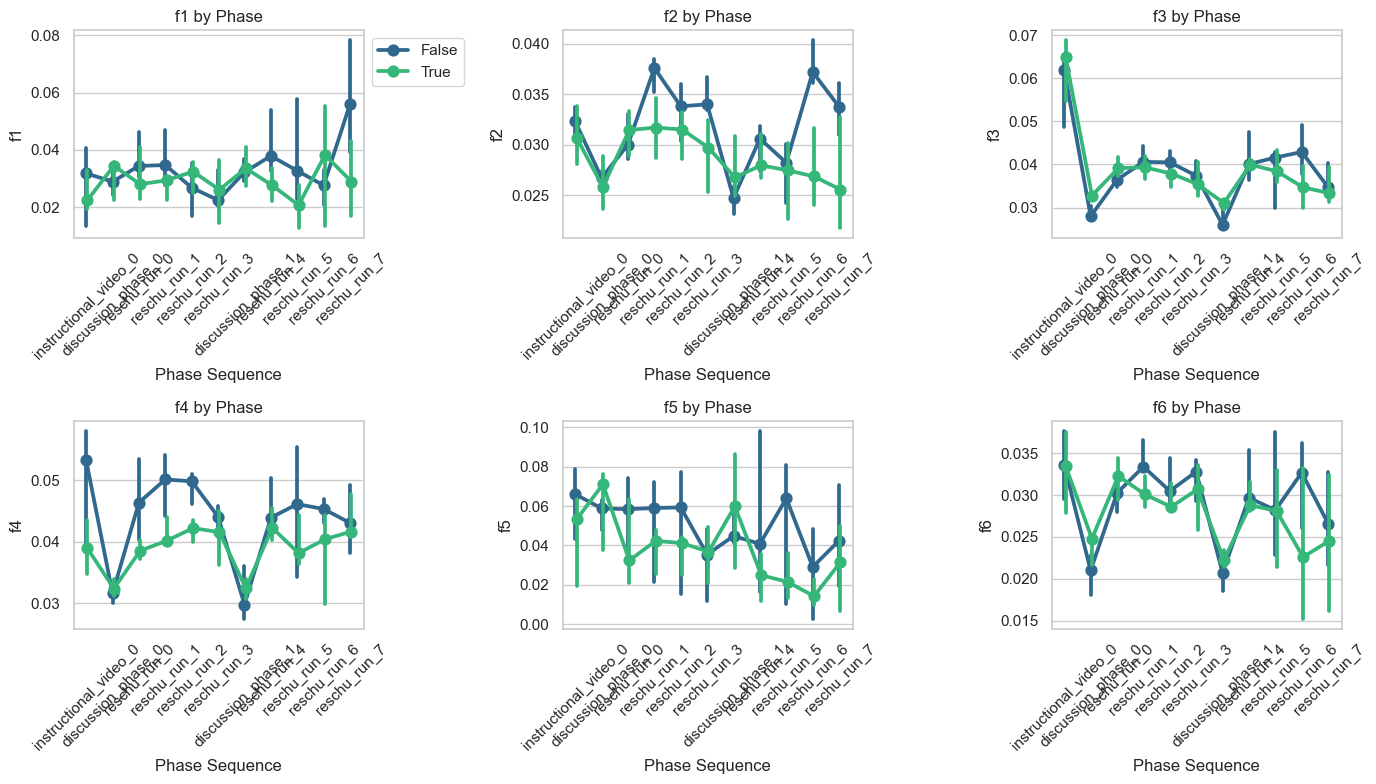

In [ ]:
# =====================================================================
# 1. Data Preparation (All Phases)
# =====================================================================

# Filter and order phases
full_df = df[df['phase'].isin(PHASES)].copy()
full_df['phase_ord'] = pd.Categorical(
    full_df['phase'],
    categories=PHASES,
    ordered=True
)
full_df['phase_num'] = full_df['phase_ord'].cat.codes + 1
full_df = full_df.reset_index(drop=True)

# Scale variables
for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'score']:
    full_df[f'{col}_scaled'] = (full_df[col] - full_df[col].mean()) / full_df[col].std()

# Check phase counts
print("Phase counts:")
print(full_df['phase'].value_counts(dropna=False).reindex(PHASES, fill_value=0))

# =====================================================================
# 2. Mixed-Effects Models (All Phase Effects)
# =====================================================================
from statsmodels.formula.api import mixedlm

all_results = []

if 'pair' not in full_df.columns:
    raise ValueError("Missing 'pair' column in your dataframe.")

for factor in ['f1_scaled', 'f2_scaled', 'f3_scaled', 'f4_scaled', 'f5_scaled', 'f6_scaled']:
    formula = f"{factor} ~ phase_ord * zoom"
    try:
        model = mixedlm(formula, data=full_df, groups=full_df["pair"])
        fit = model.fit()

        # Extract coefficients and p-values
        coef_table = pd.DataFrame({
            'term': fit.params.index,
            'coef': fit.params.values,
            'pval': fit.pvalues.values
        })

        # Filter only phase and interaction terms
        phase_terms = coef_table[coef_table['term'].str.startswith('phase_ord')]
        phase_terms['factor'] = factor

        all_results.append(phase_terms)

    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

# Combine results
if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    print("\nMixed-Effects Coefficients by Phase:")
    print(combined_results[['factor', 'term', 'coef', 'pval']])
else:
    print("No model results were collected.")

# =====================================================================
# 3. Visualization
# =====================================================================
plt.figure(figsize=(14, 8))
for i, factor in enumerate(['f1', 'f2', 'f3', 'f4', 'f5', 'f6'], 1):
    plt.subplot(2, 3, i)
    
    sns.pointplot(
        data=full_df,
        x='phase_ord',
        y=factor,
        hue='zoom',
        estimator=np.median,
        errorbar=('ci', 68),
        palette='viridis',
        dodge=True
    )
    
    plt.title(f'{factor} by Phase')
    plt.xticks(rotation=45)
    plt.xlabel('Phase Sequence')
    if i == 1:
        plt.legend(bbox_to_anchor=(1, 1))
    else:
        plt.legend().remove()

plt.tight_layout()
plt.savefig("FACE_per_phase.png", dpi=300, bbox_inches='tight')
plt.show()


Mixed Effects Model Results:

f1_scaled: coef = 0.0114, p = 0.897
f2_scaled: coef = 0.0318, p = 0.6456
f3_scaled: coef = 0.2622, p = 0.0001506
f4_scaled: coef = 0.1461, p = 0.04258
f5_scaled: coef = -0.0734, p = 0.3742
f6_scaled: coef = 0.1077, p = 0.1361
      factor      coef      pval
0  f1_scaled  0.011398  0.896950
1  f2_scaled  0.031757  0.645598
2  f3_scaled  0.262202  0.000151
3  f4_scaled  0.146117  0.042581
4  f5_scaled -0.073400  0.374154
5  f6_scaled  0.107660  0.136126


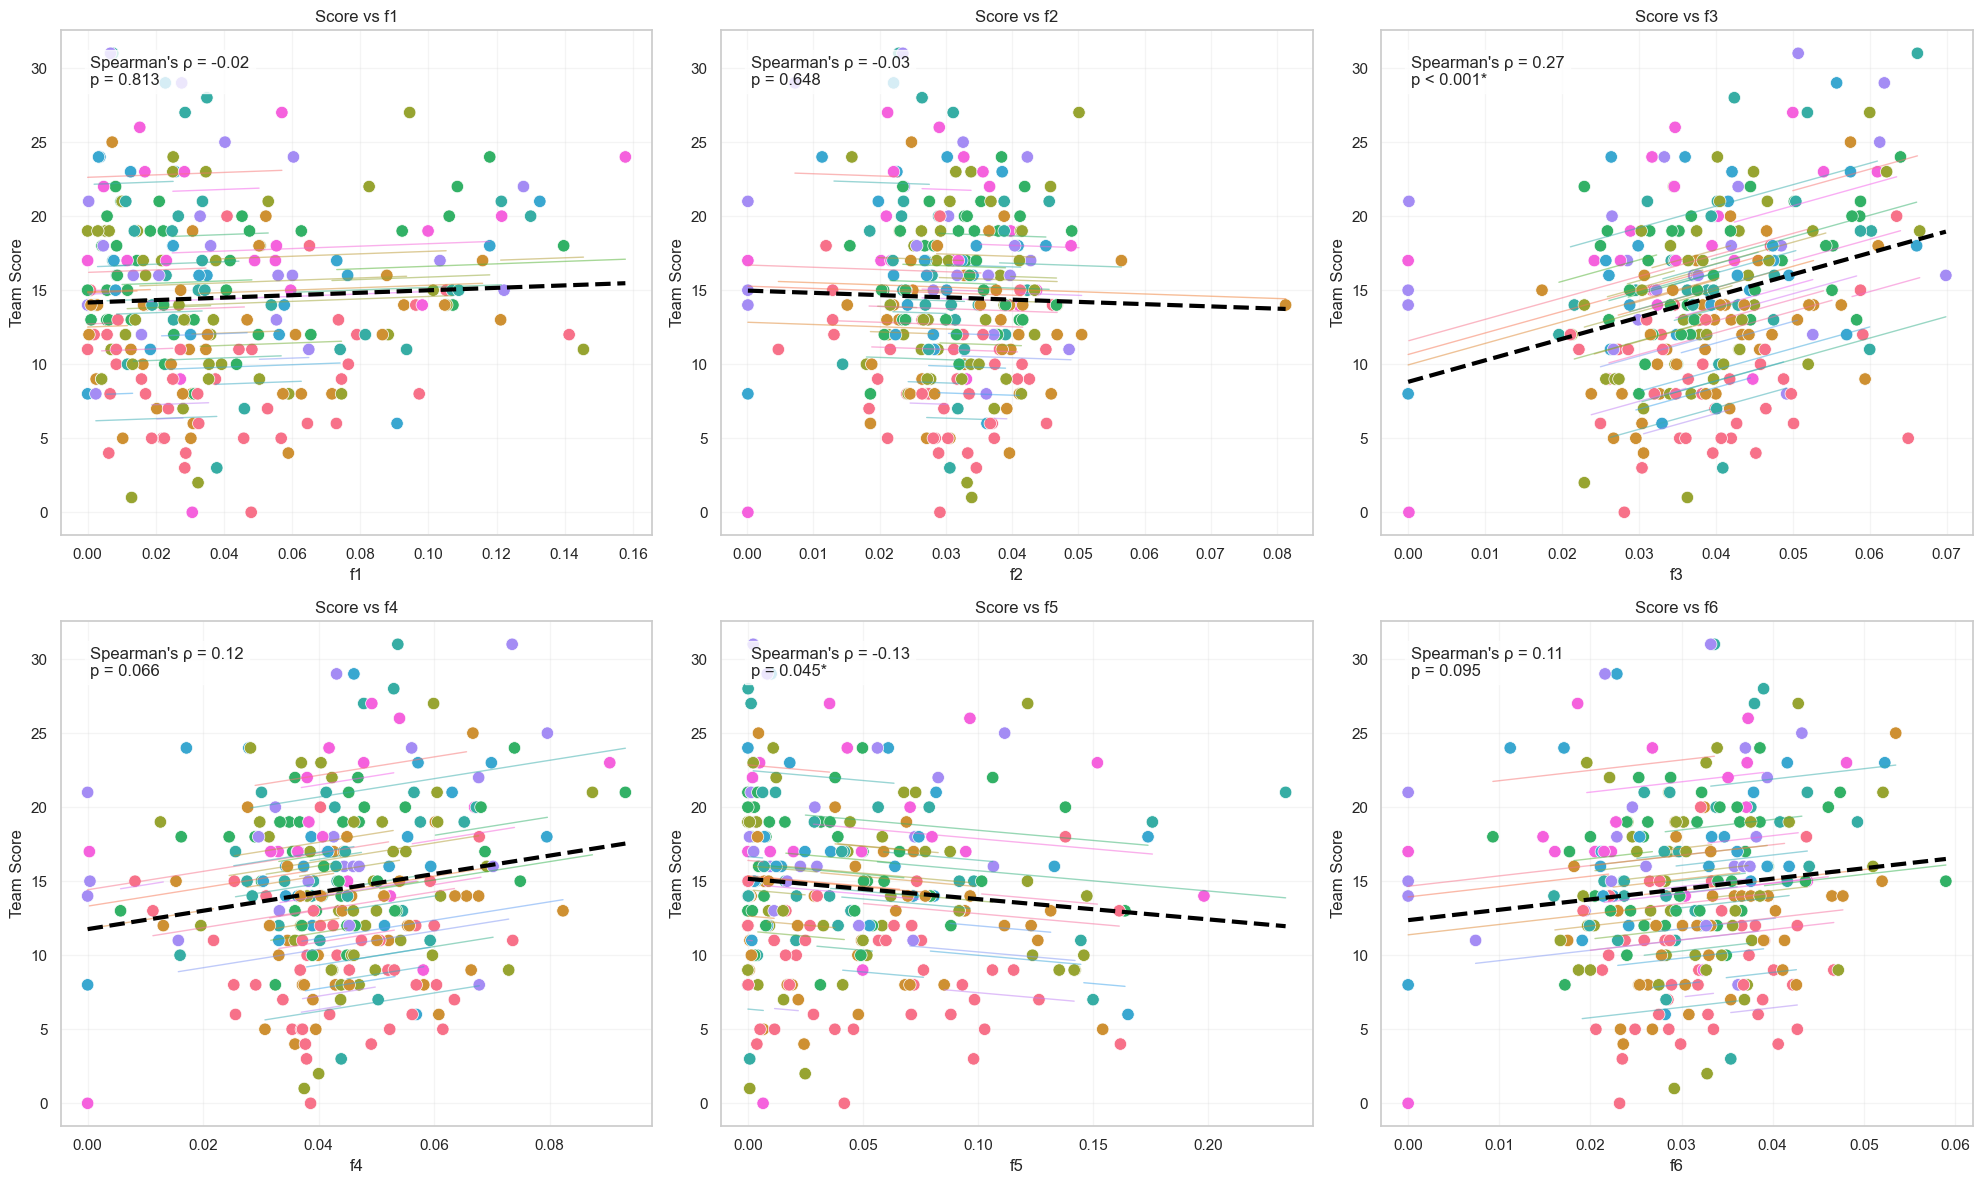

In [ ]:
# ==== 1. Filter for reschu runs ====

reschu_df = df[df['phase'].str.contains('reschu_run')].copy()
reschu_df['run_number'] = [row['phase'][-1] for _,row in reschu_df.iterrows()]

# Check participant/group ID column:
if 'pair' not in reschu_df.columns:
    raise ValueError("Please ensure your dataframe contains a 'pair' column for participant grouping.")

pairs = reschu_df['pair'].unique()
palette = sns.color_palette("husl", len(pairs))
pair_colors = dict(zip(pairs, palette))

# ==== 2. Scale predictors and outcome ====
for col in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'score']:
    reschu_df[f'{col}_scaled'] = (reschu_df[col] - reschu_df[col].mean()) / reschu_df[col].std()

predictors = ['f1_scaled', 'f2_scaled', 'f3_scaled', 'f4_scaled', 'f5_scaled', 'f6_scaled']
reschu_df = reschu_df.dropna(subset=['score'])

# ==== 3. Mixed Effects Models ====
print("Mixed Effects Model Results:\n")
results = []
for factor in predictors:
    formula = f"score_scaled ~ {factor}"
    try:
        model = smf.mixedlm(formula, data=reschu_df, groups=reschu_df['pair'])
        fit = model.fit()
        coef = fit.params[factor]
        pval = fit.pvalues[factor]
        results.append({'factor': factor, 'coef': coef, 'pval': pval})
        print(f"{factor}: coef = {coef:.4f}, p = {pval:.4g}")
    except Exception as e:
        print(f"Error fitting model for {factor}: {e}")

results_df = pd.DataFrame(results)
print(results_df)
# ==== 4. Plot all factors in subplots ====

plt.figure(figsize=(20, 12))

for i, factor in enumerate(predictors, 1):
    plt.subplot(2, 3, i)
    
    # Use original (unscaled) factor and score for plotting clarity
    orig_factor = factor.replace('_scaled', '')
    
    # Spearman correlation for annotation
    rho, p = spearmanr(reschu_df[orig_factor], reschu_df['score'])
    p_text = "p < 0.001*" if p < 0.001 else f"p = {p:.3f}*" if p<0.05 else  f"p = {p:.3f}"
    
    # Global linear regression on original data
    global_slope, global_intercept, _, _, _ = linregress(reschu_df[orig_factor], reschu_df['score'])
    
    # Scatter points, colored by run number
    sns.scatterplot(
        data=reschu_df,
        x=orig_factor,
        y='score',
        hue='run_number',
        palette='husl',
        s=80,
        edgecolor='w',
        linewidth=0.5,
        legend=False
    )
    
    # Per-pair regression lines: common slope, individual intercept
    for pair in pairs:
        pair_data = reschu_df[reschu_df['pair'] == pair]
        pair_intercept = np.mean(pair_data['score'] - global_slope * pair_data[orig_factor])
        x_vals = np.array([pair_data[orig_factor].min(), pair_data[orig_factor].max()])
        y_vals = pair_intercept + global_slope * x_vals
        plt.plot(x_vals, y_vals, color=pair_colors[pair], alpha=0.5, lw=1)
    
    # Global regression line (bold dashed)
    x_global = np.linspace(reschu_df[orig_factor].min(), reschu_df[orig_factor].max(), 100)
    y_global = global_intercept + global_slope * x_global
    plt.plot(x_global, y_global, color='black', lw=3, linestyle='--', label=f'Global Slope (β={global_slope:.2f})')
    
    # Add Spearman correlation annotation
    plt.text(
        0.05, 0.95,
        f"Spearman's ρ = {rho:.2f}\n{p_text}",
        transform=plt.gca().transAxes,
        va='top', ha='left',
        bbox=dict(facecolor='white', alpha=0.8)
    )
    
    plt.title(f'Score vs {orig_factor}')
    plt.xlabel(orig_factor)
    plt.ylabel('Team Score')
    plt.grid(alpha=0.2)

plt.tight_layout()
plt.savefig("Score_x_FACE.png", dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# NOT USED: Not evry insightful
# for factor in ['f1','f2','f4','f5','f6']:
#     g = sns.lmplot(data=reschu_df, x=factor, y='score', hue='zoom',
#                    col='phase_ord', col_wrap=4, height=3, aspect=1.2)
#     plt.suptitle(f'Score vs {factor} by phase (shaded=95% CI)', y=1.05)
#     plt.show()

In [25]:
# NOT USED: not very insightful
# # Plot coefficients with confidence intervals
# for factor in ['f1','f2','f4','f5','f6']:
#     formula = f"score_scaled ~ {factor}_scaled * zoom + phase_ord"  # Corrected line
#     model = smf.mixedlm(formula, data=reschu_df, groups=reschu_df['pair']).fit()
    
#     plt.figure(figsize=(8,4))
#     coefs = model.params[['Intercept', f'{factor}_scaled', 
#                          f'{factor}_scaled:zoom[T.True]']]
#     cis = model.conf_int().loc[coefs.index]
    
#     plt.errorbar(x=coefs.index, y=coefs, 
#                  yerr=[coefs-cis[0], cis[1]-coefs],
#                  fmt='o', capsize=5)
#     plt.axhline(0, color='grey', linestyle='--')
#     plt.title(f'{factor} fixed effects on score')
#     plt.xticks(rotation=45)
#     plt.show()

Mixed Model Results:
  factor  global_slope  global_p  zoom_slope    zoom_p
0     f1      0.050596  0.657889   -0.088198  0.616077
1     f2      0.064766  0.537529   -0.058736  0.672300
2     f3      0.369109  0.004111   -0.144553  0.338931
3     f4      0.118552  0.334563    0.050824  0.738787
4     f5     -0.011107  0.919067   -0.147734  0.367194
5     f6      0.135477  0.274615   -0.040313  0.791670


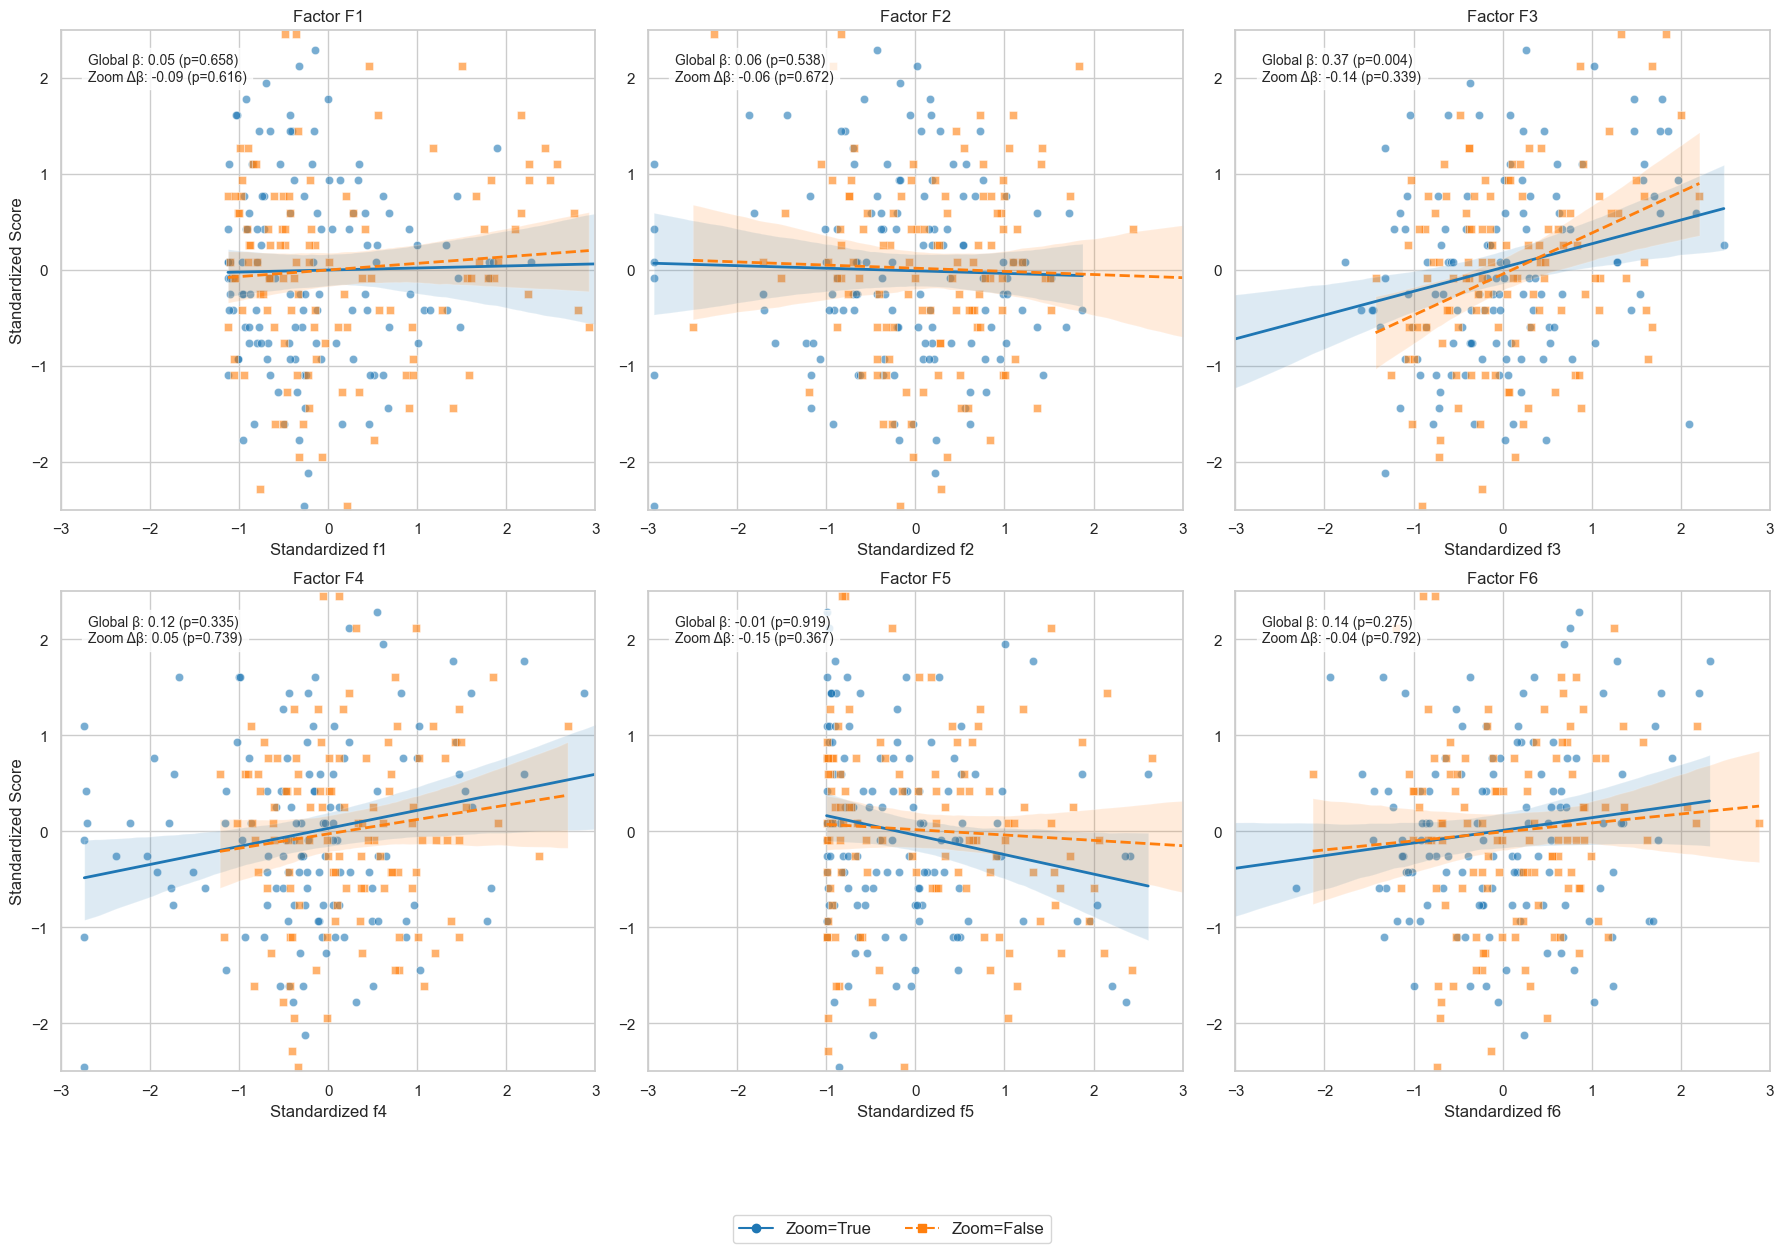

In [26]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data - Only RESCHU phases
reschu_df = df[df['phase'].str.contains('reschu_run')].copy()
factors = ['f1', 'f2','f3', 'f4', 'f5', 'f6']
reschu_df = reschu_df.dropna(subset=['score'])

# 1. Standardization
for factor in factors + ['score']:
    reschu_df[f'{factor}_std'] = (reschu_df[factor] - reschu_df[factor].mean()) / reschu_df[factor].std()

# 2. Mixed-effects modeling with random intercepts
results = []
for factor in factors:
    # Model formula (fixed effects only)
    formula = f"score_std ~ {factor}_std * zoom"
    
    # Fit model with random intercepts per pair
    model = smf.mixedlm(
        formula,
        data=reschu_df,
        groups=reschu_df['pair'],  # Random intercepts by pair
        re_formula='1'            # Explicit random intercept specification
    ).fit(reml=False)
    
    # Store results
    params = model.params
    pvals = model.pvalues
    results.append({
        'factor': factor,
        'zoom_slope': params[f'{factor}_std:zoom[T.True]'],
        'zoom_p': pvals[f'{factor}_std:zoom[T.True]'],
        'global_slope': params[f'{factor}_std'],
        'global_p': pvals[f'{factor}_std']
    })

# 3. Create results table
results_df = pd.DataFrame(results)
print("Mixed Model Results:")
print(results_df[['factor', 'global_slope', 'global_p', 'zoom_slope', 'zoom_p']])


# Create unified figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()  # Flatten to 1D array for easier indexing

# Common formatting
colors = {'True': '#1f77b4', 'False': '#ff7f0e'}
markers = {'True': 'o', 'False': 's'}
x_range = (-3, 3)  # For standardized factors
y_range = (-2.5, 2.5)  # For standardized scores

for idx, factor in enumerate(factors):
    ax = axs[idx]
    
    # Plot data points
    for zoom_condition in [True, False]:
        subset = reschu_df[reschu_df['zoom'] == zoom_condition]
        ax.scatter(
            subset[f'{factor}_std'],
            subset['score_std'],
            c=colors[str(zoom_condition)],
            marker=markers[str(zoom_condition)],
            alpha=0.6,
            edgecolor='w',
            linewidth=0.5,
            label=f'Zoom={zoom_condition}'
        )
    
    # Plot regression lines
    for zoom_condition in [True, False]:
        subset = reschu_df[reschu_df['zoom'] == zoom_condition]
        sns.regplot(
            x=subset[f'{factor}_std'],
            y=subset['score_std'],
            ax=ax,
            color=colors[str(zoom_condition)],
            scatter=False,
            ci=95,
            line_kws={'lw':2, 'ls':'-' if zoom_condition else '--'}
        )
    
    # Add model annotations
    res = results_df[results_df['factor'] == factor].iloc[0]
    text = (f"Global β: {res['global_slope']:.2f} (p={res['global_p']:.3f})\n"
            f"Zoom Δβ: {res['zoom_slope']:.2f} (p={res['zoom_p']:.3f})")
    ax.text(0.05, 0.95, text, transform=ax.transAxes,
            va='top', ha='left', fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8))
    
    # Format axes
    ax.set(xlim=x_range, ylim=y_range,
           xlabel=f'Standardized {factor}',
           ylabel='Standardized Score' if idx in [0,3] else '',
           title=f'Factor {factor.upper()}')


# Create unified legend
handles = [
    plt.Line2D([], [], color=colors['True'], marker='o', ls='-', label='Zoom=True'),
    plt.Line2D([], [], color=colors['False'], marker='s', ls='--', label='Zoom=False')
]
fig.legend(handles=handles, loc='lower center', ncol=2, 
           bbox_to_anchor=(0.5, -0.05), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Make space for legend
plt.savefig("score_x_FACE_zoom.png", dpi=300, bbox_inches='tight')
plt.show()

## delay analysis

Data columns: 121, Expected: 121
Condition 1 mean: 0.026
Condition 2 mean: 0.036
Condition 3 mean: 0.036
Data columns: 121, Expected: 121
Condition 1 mean: 0.047
Condition 2 mean: 0.037
Condition 3 mean: 0.047
6


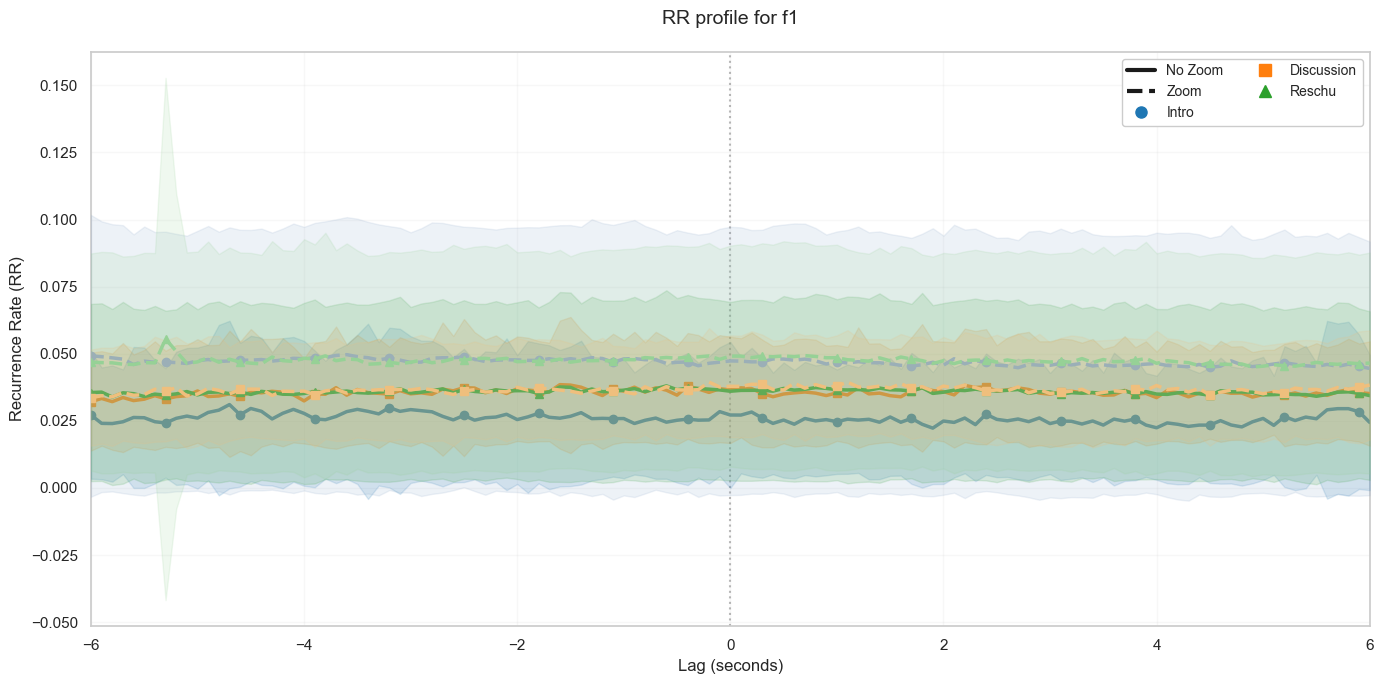

Data columns: 121, Expected: 121
Condition 1 mean: 0.034
Condition 2 mean: 0.030
Condition 3 mean: 0.030
Data columns: 121, Expected: 121
Condition 1 mean: 0.032
Condition 2 mean: 0.027
Condition 3 mean: 0.033
6


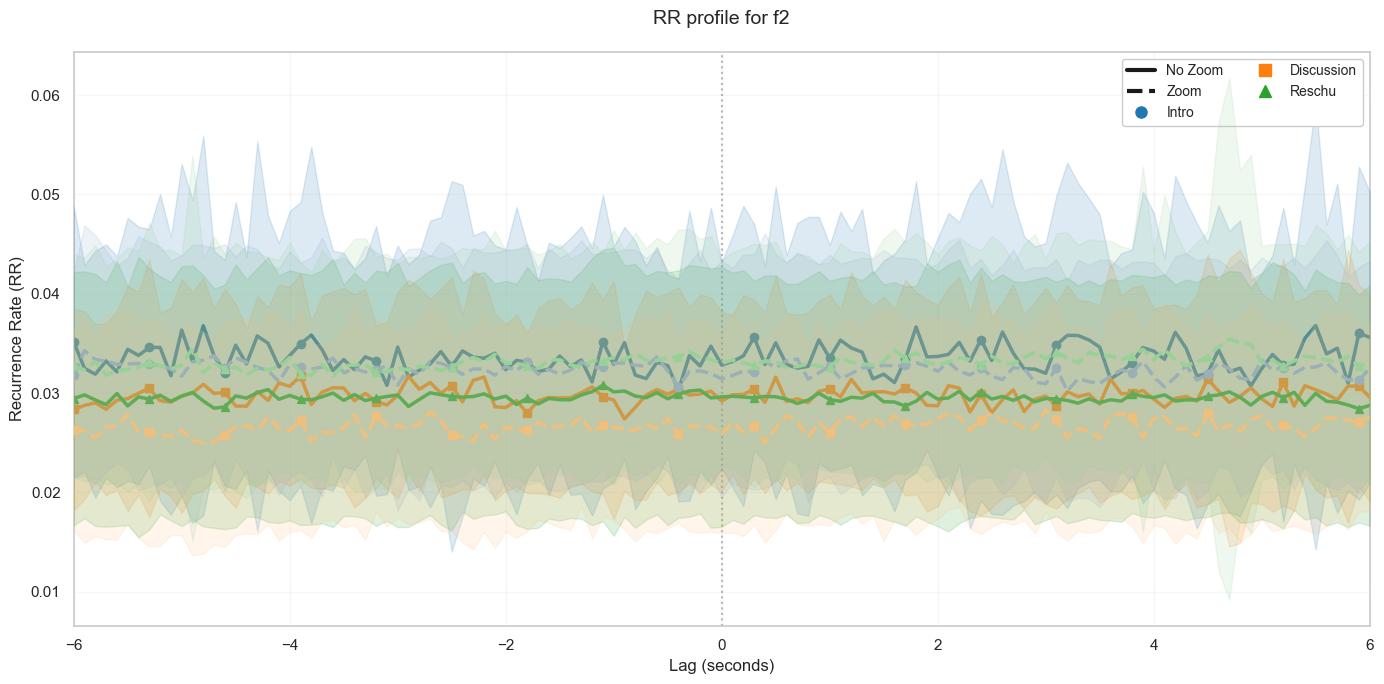

Data columns: 121, Expected: 121
Condition 1 mean: 0.065
Condition 2 mean: 0.033
Condition 3 mean: 0.039
Data columns: 121, Expected: 121
Condition 1 mean: 0.058
Condition 2 mean: 0.030
Condition 3 mean: 0.042
6


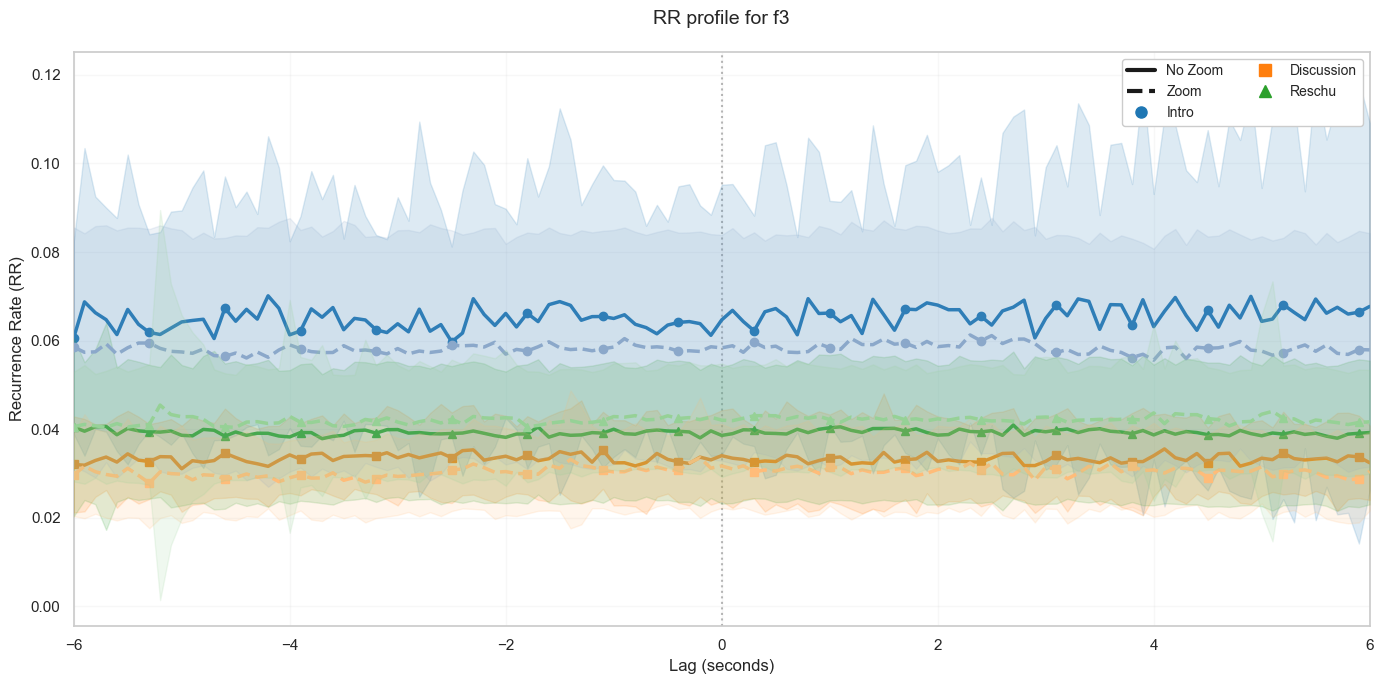

Data columns: 121, Expected: 121
Condition 1 mean: 0.040
Condition 2 mean: 0.033
Condition 3 mean: 0.041
Data columns: 121, Expected: 121
Condition 1 mean: 0.049
Condition 2 mean: 0.033
Condition 3 mean: 0.048
6


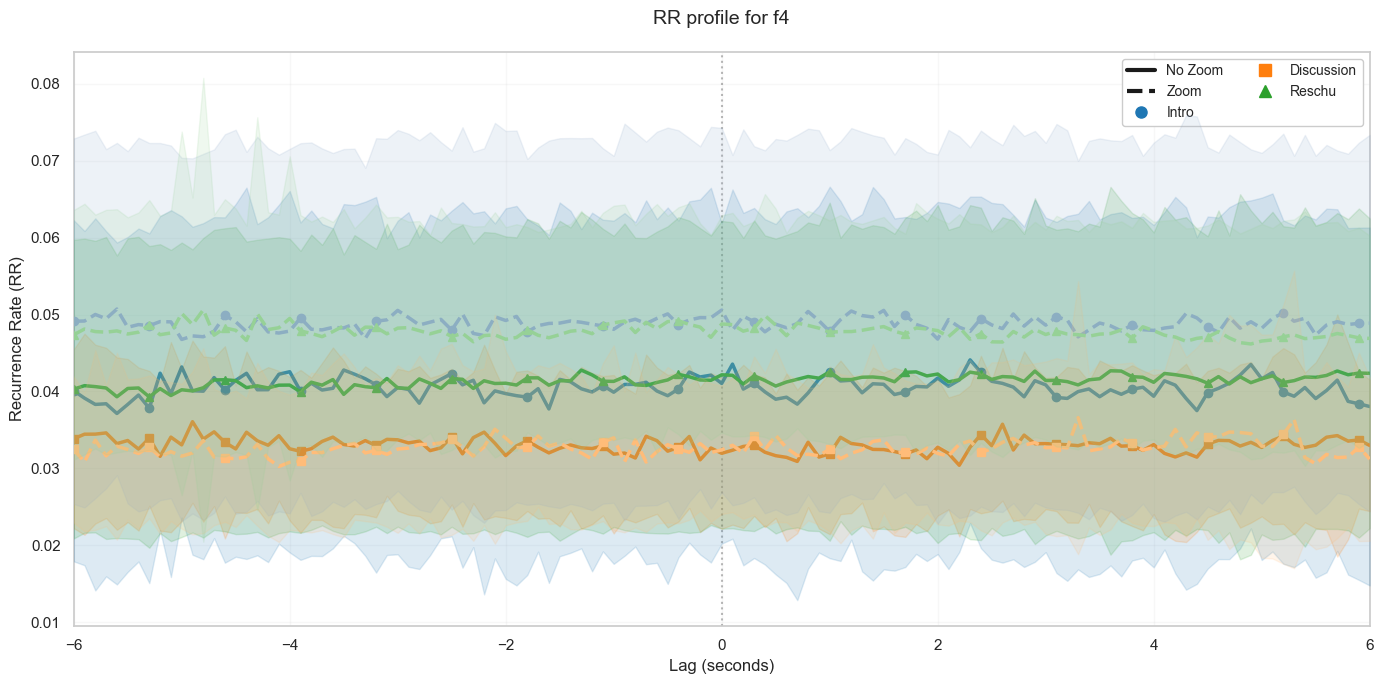

Data columns: 121, Expected: 121
Condition 1 mean: 0.068
Condition 2 mean: 0.064
Condition 3 mean: 0.040
Data columns: 121, Expected: 121
Condition 1 mean: 0.071
Condition 2 mean: 0.052
Condition 3 mean: 0.056
6


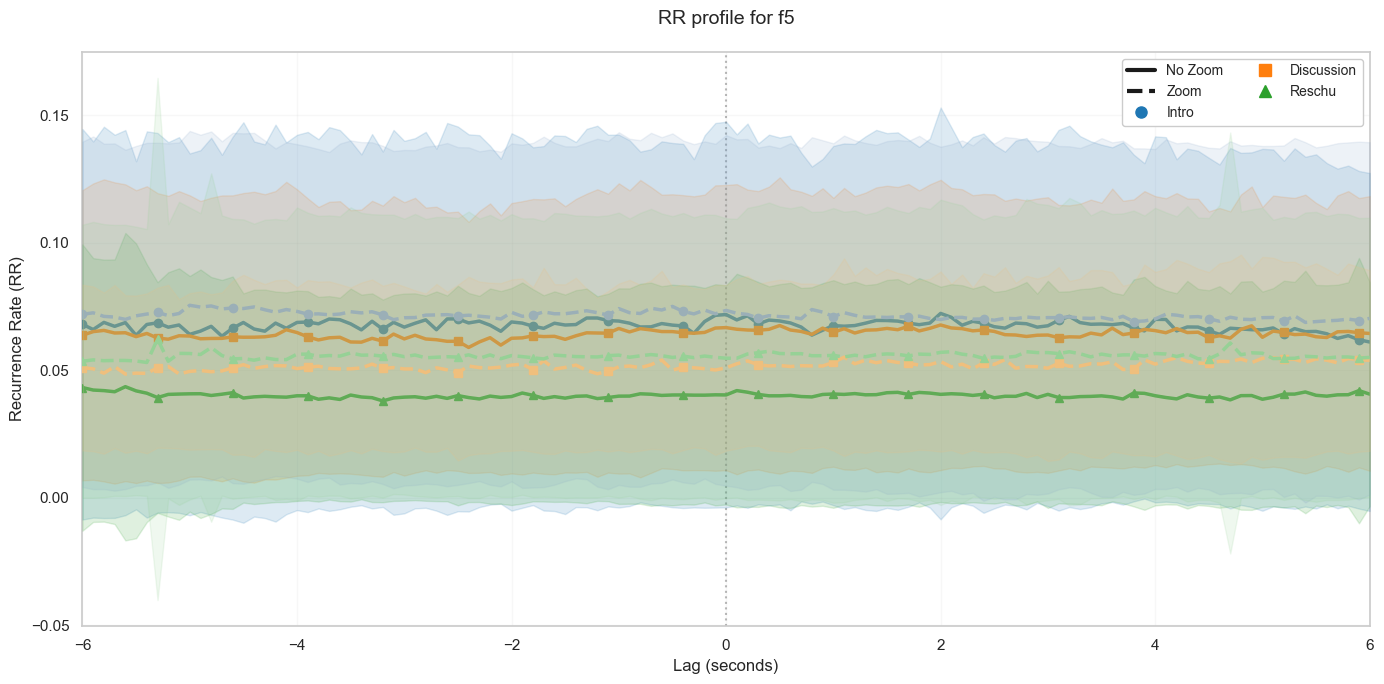

Data columns: 121, Expected: 121
Condition 1 mean: 0.034
Condition 2 mean: 0.025
Condition 3 mean: 0.029
Data columns: 121, Expected: 121
Condition 1 mean: 0.033
Condition 2 mean: 0.020
Condition 3 mean: 0.032
6


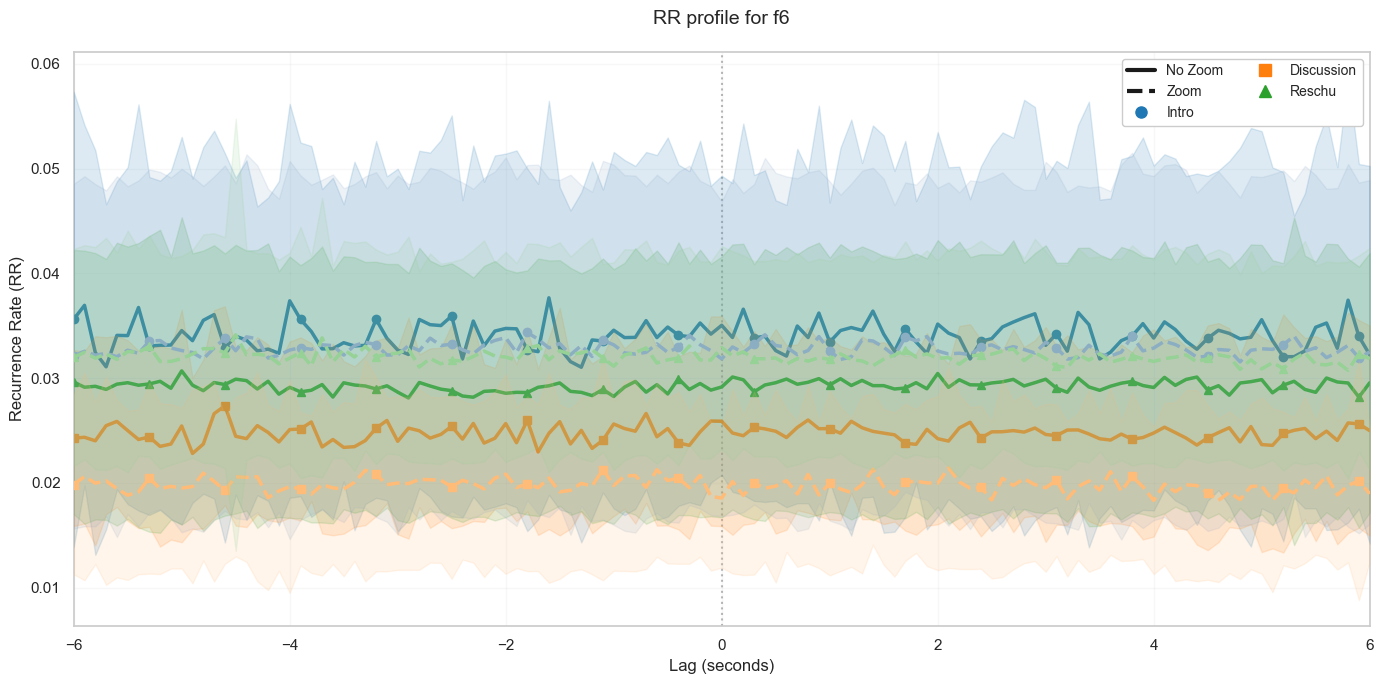

In [18]:
import util.visualisation as vis
import pandas as pd
df = pd.read_csv('crqa_NEM-_profile.csv')
vis.delay_profile(df)